In [1]:
def merge_close_timestamps(data, threshold=0.1):
    """
    Merges entries in data if their start times are within the given threshold.
    
    :param data: List of tuples (start, end, word)
    :param threshold: Time difference threshold for merging
    :return: List of merged tuples (start, end, word)
    """
    if not data:
        return []
    
    # Sort by start time
    data.sort()
    
    merged = []
    cur_start, cur_end, cur_word = data[0]
    
    for start, end, word in data[1:]:
        if start - cur_start <= threshold:
            # Merge words and update end time
            cur_end = max(cur_end, end)
            cur_word += " " + word
        else:
            # Append the current merged segment and start a new one
            merged.append((cur_start, cur_end, cur_word))
            cur_start, cur_end, cur_word = start, end, word
    
    # Append the last merged segment
    merged.append((cur_start, cur_end, cur_word))
    
    return merged

# Example usage
data = [(0.0, 0.5, "hello"), (0.6, 1.0, "world"), (1.1, 1.4, "how"), (1.15, 1.5, "are you")]
merged_data = merge_close_timestamps(data, threshold=0.3)
print(merged_data)

[(0.0, 0.5, 'hello'), (0.6, 1.0, 'world'), (1.1, 1.5, 'how are you')]


In [2]:
import pandas as pd
from pathlib import Path
import json
import librosa
import numpy as np
import matplotlib.pyplot as plt

def plot_importance(filename, importance_file, remove_silence=False, labels=[None], thr=0):
    df_cough = pd.read_csv('/home/ec2-user/mnt/data/IEMOCAP-happy-cough/metadata.csv')
    df_cough['stem'] = df_cough['filename'].apply(lambda x: Path(x).stem)
    cough_row = df_cough.loc[df_cough['stem'] == Path(filename).stem]
 
    x, fs = librosa.core.load("/home/ec2-user" + filename, sr=16000)
    x = x[int(0.4*fs):int(7.32*fs)]
    if not isinstance(importance_file, list):
        importance_file = []
    importances = []
    for fname in importance_file:
        with open(fname, 'r') as f:
            ip = json.load(f)
            print(ip['metadata'])
            if ('true_markers' in ip['metadata']) and (len(ip['metadata']['true_markers']) > 0):
                gt_markers = ip['metadata']['true_markers'][0]
            ip = np.array(ip['importance_scores']['RF']['values'])
            
            importances.append(ip)
    total_duration = x.shape[0]/fs
    importance_t = np.linspace(0, total_duration, importances[0].shape[0])

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7,4), height_ratios=[1,1.6])
    cough_filename = cough_row['cough_filename'].values[0]
    cough_path = '/home/ec2-user/mnt/data/esc50-v2.0.0-full/16000/fold0{}/{}'.format(int(cough_filename.split('-')[0])-1, cough_filename)
    cough, fs = librosa.core.load(cough_path, sr=16000)
    splits = librosa.effects.split(cough)
    cough_end = splits[-1][-1]
    if cough_end > int(x.shape[0]*0.2):
        cough_end = int(x.shape[0]*0.2)
    
    cough = cough[:cough_end]
    cough_ = np.zeros_like(x)
    cough_[int(cough_row['cough_start'].values[0]-0.4*fs): int(cough_row['cough_end'].values[0]-0.4*fs)] = cough
    print(cough_row['speech_filename'])
    speech, fs = librosa.core.load("/home/ec2-user" + cough_row['speech_filename'].values[0], sr=None)
    speech = speech[int(0.4*fs):int(7.32*fs)]
    trans_file = str(Path("/home/ec2-user" + cough_row['speech_filename'].values[0]).resolve()).replace('/wav','/ForcedAlignment').replace('.wav','.wdseg')
    y_text = -1.3
    with open(trans_file, 'r') as f:
        trans = f.read()
        trans_rows = trans.split('\n')
        starts = []
        ends = []
        words = []
        for i, r in enumerate(trans_rows):
            if i>0 and (i<len(trans_rows)-2):
                r_parts = r.split()
                word = r_parts[-1].split('(')[0]
                if word in ['<s>','<sil>']:
                    word = ''
                if word == '</s>':
                    word = '(LAUGH)'
                start = int(r_parts[0])/100.0
                end = int(r_parts[1])/100.0 + 0.01
                starts.append(start)
                ends.append(end)
                words.append(word)
    print(words)
    starts = starts[2:-1]
    words = words[2:-1]
    ends = ends[2:-1]
    if thr>0:
        data = [(si,ei,wi) for si,ei,wi in zip(starts,ends,words)]
        print(data)
        merged = merge_close_timestamps(data, thr)
        print(merged)
        starts = [m[0] for m in merged]
        ends = [m[1] for m in merged]
        words = [m[2] for m in merged]

    if remove_silence:
        speech = speech[int(starts[1]*fs):int(starts[-1]*fs)]
        cough_ = cough_[int(starts[1]*fs):int(starts[-1]*fs)]
        gt_markers = [gt_markers[0]-starts[1], gt_markers[1]-starts[1]]
        total_duration = speech.shape[0]/fs
        ws = starts[1]
        starts = starts[1:-1]
        ends = ends[1:-1]
        words = words[1:-1]
        
        starts = [s - ws for s in starts]
        ends = [e - ws for e in ends]
        start_idx = int(np.floor(10*ws))
        end_idx = int(np.floor(10*(ends[-1] + ws)))
        importances = [ip[start_idx:end_idx] for ip in importances]
        importance_t = np.linspace(0, total_duration, importances[0].shape[0])
        
    gt_markers = [2.85025 - 0.4, 3.49025 - 0.4]
    starts = [s - 0.4 for s in starts]
    ends = [e - 0.4 for e in ends]
    t = np.linspace(0,total_duration,speech.shape[0])
    last_pos = 0
    for s, e, w in zip(starts, ends, words):
        pos = e
        last_pos = pos
        text = ax[0].text(pos, y_text, w, fontsize=10, 
             ha='right', va='top', rotation=40)
        #bbox = text.get_window_extent(renderer=ax[0].figure.canvas.get_renderer())
        #text_width = bbox.width / ax[0].figure.dpi  # Convert to data coordinates
        #pos_adjusted = pos - text_width / 2  # Shift left slightly
        #text.set_x(pos_adjusted)
    ax[0].plot(t, speech/np.max(np.abs(speech)), c='b', alpha=0.5)
    ax[0].plot(t, cough_/np.max(np.abs(cough_)), c='r', alpha=0.5)
    ax[0].vlines(x=gt_markers,ymin=-1.1,ymax=x.max()+1.1, color='k', linestyle='--', linewidth=1)
    ax[0].set_ylim(-1.1, 1.1)
    ax[0].set_xlim(0, total_duration)
    ax[0].set_ylabel('Amplitude')
    ax[0].set_xticks(starts)
    ax[0].set_xticklabels(['']*len(starts))
    #ax[0].spines['bottom'].set_position(('data', - 1.15))  # Shift x-axis down
    ax[0].tick_params(axis='x', length=7)

    colors = ['r','b']
    for i,ip in enumerate(importances):
        ax[1].plot(importance_t, ip,  drawstyle='steps-mid', c=colors[i], label=labels[i])
    ax[1].vlines(x=gt_markers,ymin=importances[0].min()-0.1,ymax=importances[0].max()+0.1, color='k', linestyle='--', linewidth=1)
    ax[1].set_ylim(importances[0].min(), importances[0].max()+0.01)
    ax[1].set_ylabel('RF importance')
    ax[1].set_xlim(0, total_duration)
    ax[1].set_xlabel('Time (s)')
    ax[1].legend(title='Classifier Training Data', bbox_to_anchor=[1.01,1.04,0,0])
    
    fig.align_ylabels()
    plt.tight_layout()
    # plt.savefig('importances.pdf')

{'filename': 'Ses05F_impro03_M037.wav', 'id_explained': 1.0, 'segment_length': 100, 'true_markers': [[2.85025, 3.49025]], 'true_score': 2.9087593324772136}
{'filename': 'Ses05F_impro03_M037.wav', 'id_explained': 1.0, 'segment_length': 100, 'true_markers': [], 'true_score': -1.4785061179987937}
4395    /mnt/data/IEMOCAP/Session5/sentences/wav/Ses05...
Name: speech_filename, dtype: object
['', '', 'THE', 'EXACT', 'RIGHT', 'GUY', 'I', '', 'FULLY', 'APPROVE', '', "HE'S", '', 'A', 'WONDERFUL', 'GUY', '', 'WE', 'HAVE', 'A', 'GREAT', 'TIME', '', 'HE', 'CAN', 'DRINK', '', "THAT'S", 'AWESOME', '(LAUGH)']
[(0.4, 0.5, 'THE'), (0.5, 0.89, 'EXACT'), (0.89, 1.12, 'RIGHT'), (1.12, 1.52, 'GUY'), (1.52, 1.81, 'I'), (1.81, 1.84, ''), (1.84, 2.4, 'FULLY'), (2.4, 2.9299999999999997, 'APPROVE'), (2.93, 2.96, ''), (2.96, 3.1999999999999997, "HE'S"), (3.2, 3.48, ''), (3.48, 3.59, 'A'), (3.59, 4.08, 'WONDERFUL'), (4.08, 4.46, 'GUY'), (4.46, 5.22, ''), (5.22, 5.319999999999999, 'WE'), (5.32, 5.41, 'HAVE'), (5.

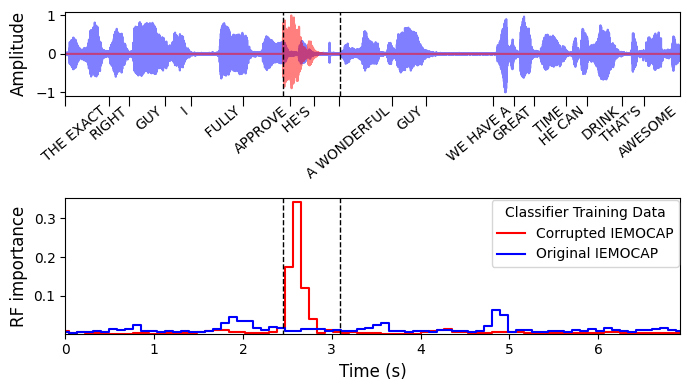

In [3]:
plt.rcParams.update({'font.size': 10})
plt.rc('axes', labelsize=12)
plot_importance('/mnt/data/IEMOCAP-happy-cough/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M037.wav', 
                ['/home/ec2-user/results/explanations_cough/Ses05F_impro03_M037.wav/cough/ft_1_zeros.json','/home/ec2-user/results/explanations_nocough/Ses05F_impro03_M037.wav/nocough/ft_1_zeros.json'], 
                remove_silence=False,
                labels=['Corrupted IEMOCAP','Original IEMOCAP'],
                thr=0.2)

In [16]:
import pandas as pd
from pathlib import Path
import json
import librosa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import os
import base64
from IPython.display import HTML, display
import io
import subprocess

def animate_plot(filename, importance_file, output_video="animation.mp4", remove_silence=False, labels=[None, None], thr=0.2, fps=30, display_animation=True):
    print("Starting animation generation...")
    # Load data and setup similar to the original plot_importance function
    df_cough = pd.read_csv('/home/ec2-user/mnt/data/IEMOCAP-happy-cough/metadata.csv')
    df_cough['stem'] = df_cough['filename'].apply(lambda x: Path(x).stem)
    cough_row = df_cough.loc[df_cough['stem'] == Path(filename).stem]
 
    x, fs = librosa.core.load("/home/ec2-user" + filename, sr=16000)
    # x = x[int(0.4*fs):int(7.32*fs)]
    
    if not isinstance(importance_file, list):
        importance_file = [importance_file]
    
    importances = []
    # gt_markers = [2.85025 - 0.4, 3.49025 - 0.4]  # Default values
    
    for fname in importance_file:
        with open(fname, 'r') as f:
            ip = json.load(f)
            print(f"Loaded importance file: {fname}")
            if ('true_markers' in ip['metadata']) and (len(ip['metadata']['true_markers']) > 0):
                gt_markers = ip['metadata']['true_markers'][0]
                print(f"Found ground truth markers: {gt_markers}")
            ip = np.array(ip['importance_scores']['RF']['values'])
            importances.append(ip)
    
    total_duration = x.shape[0]/fs
    importance_t = np.linspace(0, total_duration, importances[0].shape[0])
    
    # Setup figure for animation
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.rcParams['figure.dpi'] = 100
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), height_ratios=[1, 1.6])
    fig.tight_layout(pad=3.0)
    
    # Get cough data
    cough_filename = cough_row['cough_filename'].values[0]
    cough_path = '/home/ec2-user/mnt/data/esc50-v2.0.0-full/16000/fold0{}/{}'.format(
        int(cough_filename.split('-')[0])-1, cough_filename)
    cough, fs = librosa.core.load(cough_path, sr=16000)
    splits = librosa.effects.split(cough)
    cough_end = splits[-1][-1]
    if cough_end > int(x.shape[0]*0.2):
        cough_end = int(x.shape[0]*0.2)
    
    cough = cough[:cough_end]
    cough_ = np.zeros_like(x)
    print(len(cough_))
    cough_[int(cough_row['cough_start'].values[0]): int(cough_row['cough_end'].values[0])] = cough
    
    # Load speech data
    speech, fs = librosa.core.load("/home/ec2-user" + cough_row['speech_filename'].values[0], sr=None)

    # speech = speech[int(0.4*fs):int(7.32*fs)]
    
    # Load transcript
    trans_file = str(Path("/home/ec2-user" + cough_row['speech_filename'].values[0]).resolve()).replace('/wav','/ForcedAlignment').replace('.wav','.wdseg')
    y_text = -1.3
    
    starts = []
    ends = []
    words = []
    
    with open(trans_file, 'r') as f:
        trans = f.read()
        trans_rows = trans.split('\n')
        for i, r in enumerate(trans_rows):
            if i > 0 and (i < len(trans_rows) - 2):
                r_parts = r.split()
                if len(r_parts) >= 2:  # Make sure there are enough parts
                    word = r_parts[-1].split('(')[0] if len(r_parts) > 0 else ""
                    if word in ['<s>', '<sil>']:
                        word = ''
                    if word == '</s>':
                        word = '(LAUGH)'
                    try:
                        start = float(r_parts[0]) / 100.0
                        end = float(r_parts[1]) / 100.0 + 0.01
                        starts.append(start)
                        ends.append(end)
                        words.append(word)
                    except (ValueError, IndexError) as e:
                        print(f"Error parsing line: {r}, error: {e}")
    
    if len(starts) > 2:
        starts = starts[2:-1]
        words = words[2:-1]
        ends = ends[2:-1]

    if thr>0:
        data = [(si,ei,wi) for si,ei,wi in zip(starts,ends,words)]
        print(data)
        merged = merge_close_timestamps(data, thr)
        print(merged)
        starts = [m[0] for m in merged]
        ends = [m[1] for m in merged]
        words = [m[2] for m in merged]

    
    if remove_silence and len(starts) >= 2:
        speech = speech[int(starts[1]*fs):int(starts[-1]*fs)]
        cough_ = cough_[int(starts[1]*fs):int(starts[-1]*fs)]
        gt_markers = [gt_markers[0]-starts[1], gt_markers[1]-starts[1]]
        total_duration = speech.shape[0]/fs
        ws = starts[1]
        starts = starts[1:-1]
        ends = ends[1:-1]
        words = words[1:-1]
        
        starts = [s - ws for s in starts]
        ends = [e - ws for e in ends]
        start_idx = int(np.floor(10*ws))
        end_idx = int(np.floor(10*(ends[-1] + ws))) if ends else start_idx + 1
        importances = [ip[start_idx:end_idx] for ip in importances]
        importance_t = np.linspace(0, total_duration, importances[0].shape[0])
    
    # starts = [s - 0.4 for s in starts]
    # ends = [e - 0.4 for e in ends]
    t = np.linspace(0, total_duration, speech.shape[0])
    
    # Setup for animation
    num_frames = int(np.ceil(total_duration * fps))
    print(f"Creating animation with {num_frames} frames at {fps} fps")
    
    # MODIFICATION: Plot all audio data from the beginning
    normalized_speech = speech / np.max(np.abs(speech)) if len(speech) > 0 and np.max(np.abs(speech)) > 0 else []
    normalized_cough = cough_ / np.max(np.abs(cough_)) if len(cough_) > 0 and np.max(np.abs(cough_)) > 0 else []

    # Plot all audio waveforms at once
    audio_line, = ax[0].plot(t, normalized_speech, c='b', alpha=0.5, label='Speech')
    cough_line, = ax[0].plot(t, normalized_cough, c='r', alpha=0.5, label='Cough')
    ax[0].vlines(x=gt_markers, ymin=-1.1, ymax=1.1, color='k', linestyle='--', linewidth=1)
    ax[0].set_ylim(-1.1, 1.1)
    ax[0].set_xlim(0, total_duration)
    ax[0].set_ylabel('Amplitude')
    ax[0].legend(loc='upper right')

    # Progress marker (vertical line that moves with time)
    # FIXED: Initialize with array instead of single value
    progress_line = ax[0].axvline(x=[0], color='g', linewidth=2, alpha=0.7)
    progress_line_bottom = ax[1].axvline(x=[0], color='g', linewidth=2, alpha=0.7)
    
    # MODIFICATION: Plot all importance data from the beginning
    importance_lines = []
    colors = ['r', 'b']
    for i, ip in enumerate(importances):
        label = labels[i] if i < len(labels) and labels[i] is not None else f"Importance {i+1}"
        line, = ax[1].plot(importance_t, ip, drawstyle='steps-mid', c=colors[i], label=label)
        importance_lines.append(line)
    
    # Set up axes
    
    ax[1].vlines(x=gt_markers,ymin=importances[0].min()-0.1,ymax=importances[0].max()+0.1, color='k', linestyle='--', linewidth=1)    
    ax[1].set_ylim(importances[0].min(), importances[0].max()+0.01)
    ax[1].set_ylabel('RF importance')
    ax[1].set_xlim(0, total_duration)
    ax[1].set_xlabel('Time (s)')
    
    # MODIFICATION: Add all word labels from the beginning with 0 alpha
    word_texts = []
    for s, e, w in zip(starts, ends, words):
        text = ax[0].text(e, y_text, w, fontsize=8, ha='right', va='top', rotation=45, alpha=0)
        word_texts.append((s, e, text))  # Store start time with the text object
    
    def init():
        # FIXED: Use arrays for xdata
        progress_line.set_xdata([0])
        progress_line_bottom.set_xdata([0])
        
        # Set all word texts to invisible
        for _, _, text in word_texts:
            text.set_alpha(1.0)
            
        return [progress_line, progress_line_bottom] + [text for _, _, text in word_texts]
    
    def animate(frame):
        # Calculate current time
        current_time = frame / fps
        
        # FIXED: Use arrays for xdata
        progress_line.set_xdata([current_time])
        progress_line_bottom.set_xdata([current_time])
        # Print progress occasionally
        if frame % (num_frames // 10) == 0:
            print(f"Animation progress: {frame}/{num_frames} frames ({frame/num_frames*100:.1f}%)")
            
        return [progress_line, progress_line_bottom] + [text for _, _, text in word_texts]
    
    # Create animation - use blit=True for faster rendering, if it causes problems switch to False
    try:
        ani = FuncAnimation(fig, animate, frames=num_frames, init_func=init, blit=False, interval=1000/fps)
        print("Animation created successfully with blit=True")
    except Exception as e:
        print(f"Error with blit=True: {e}")
        print("Trying with blit=False")
        plt.close(fig)
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), height_ratios=[1, 1])
        ani = FuncAnimation(fig, animate, frames=num_frames, init_func=init, blit=False, interval=1000/fps)
        print("Animation created successfully with blit=False")
    
    # Save animation
    print(f"Saving animation to {output_video}...")
    try:
        # Try using FFMpegWriter if available
        writer = animation.FFMpegWriter(fps=fps, metadata=dict(artist='Me'), bitrate=1800)
        ani.save(output_video, writer=writer)
        print(f"Animation saved to {output_video} using FFMpegWriter")
    except Exception as e1:
        print(f"Error saving with FFMpegWriter: {e1}")
        try:
            # Fallback to other writers if FFMpegWriter fails
            ani.save(output_video, fps=fps, writer='pillow', dpi=100)
            print(f"Animation saved to {output_video} using pillow writer")
        except Exception as e2:
            print(f"Error saving with pillow writer: {e2}")
            print("Attempting to save with default writer...")
            ani.save(output_video)
            print(f"Animation saved to {output_video} with default writer")
    
    # Display the animation in notebook if requested
    if display_animation:
        try:
            if output_video.endswith('.mp4'):
                # For Jupyter notebook, try to display the video
                print("Displaying animation in notebook...")
                video = open(output_video, "rb").read()
                video_url = f"data:video/mp4;base64,{base64.b64encode(video).decode('utf-8')}"
                display(HTML(f"""
                <video width="100%" height="auto" controls>
                    <source src="{video_url}" type="video/mp4">
                </video>
                """))
            else:
                # For other formats, just display the path
                print(f"Animation saved to {output_video}. Please open this file to view it.")
        except Exception as e:
            print(f"Error displaying animation: {e}")
            print(f"You can find the animation at: {os.path.abspath(output_video)}")
    print(f"Duración del audio: {total_duration} segundos")
    print(f"Duración de la animación: {num_frames / fps} segundos")
    plt.close()
    print(f"Animation process completed.")
    file_path = "/home/ec2-user" + filename
    command = [
        'ffmpeg', '-y', '-i', output_video, '-i', file_path, 
        '-c:v', 'copy', '-c:a', 'aac', '-strict', 'experimental', "Ses05F_impro03_M037.mp4", '-ar', '16000', 
    ]
    subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    return output_video

# Function to check if we're in a Jupyter notebook
def is_jupyter():
    try:
        from IPython import get_ipython
        if get_ipython() is None:
            return False
        if 'IPKernelApp' not in get_ipython().config:
            return False
        return True
    except ImportError:
        
        return False

In [17]:
if __name__ == "__main__":
    # Use the actual file paths from the error message
    audio_file = '/mnt/data/IEMOCAP-happy-cough/Session5/sentences/wav/Ses05F_impro03/Ses05F_impro03_M037.wav'
    importance_files = [ 
        '/home/ec2-user/results/explanations_cough/Ses05F_impro03_M037.wav/cough/ft_1_zeros.json',
        '/home/ec2-user/results/explanations_nocough/Ses05F_impro03_M037.wav/nocough/ft_1_zeros.json'
    ]
    # audio_file = '/explain_where/plots/cough/cough.wav'
    # importance_files = [
    #     '/home/ec2-user/explain_where/plots/cough/ft2_1_zeros_cough.json',
    #     '/home/ec2-user/explain_where/plots/cough/ft2_1_zeros_nocough.json'
    # ]
    # Set display_animation based on environment
    in_jupyter = is_jupyter()
    print(f"Running in Jupyter notebook: {in_jupyter}")
    
    animate_plot(
        filename=audio_file,
        importance_file=importance_files,
        output_video="test.mp4",
        labels=["Cough", "No Cough"],
        thr=0.1,
        fps=30,
        display_animation=in_jupyter  # Auto-detect if we should try to display inline
    )
    
    print("\nIf the animation isn't displayed automatically, you can find it at:")
    print(os.path.abspath("audio_analysis_animation.mp4"))

Running in Jupyter notebook: True
Starting animation generation...
Loaded importance file: /home/ec2-user/results/explanations_cough/Ses05F_impro03_M037.wav/cough/ft_1_zeros.json
Found ground truth markers: [2.85025, 3.49025]
Loaded importance file: /home/ec2-user/results/explanations_nocough/Ses05F_impro03_M037.wav/nocough/ft_1_zeros.json
123840
[(0.4, 0.5, 'THE'), (0.5, 0.89, 'EXACT'), (0.89, 1.12, 'RIGHT'), (1.12, 1.52, 'GUY'), (1.52, 1.81, 'I'), (1.81, 1.84, ''), (1.84, 2.4, 'FULLY'), (2.4, 2.9299999999999997, 'APPROVE'), (2.93, 2.96, ''), (2.96, 3.1999999999999997, "HE'S"), (3.2, 3.48, ''), (3.48, 3.59, 'A'), (3.59, 4.08, 'WONDERFUL'), (4.08, 4.46, 'GUY'), (4.46, 5.22, ''), (5.22, 5.319999999999999, 'WE'), (5.32, 5.41, 'HAVE'), (5.41, 5.45, 'A'), (5.45, 5.68, 'GREAT'), (5.68, 6.04, 'TIME'), (6.04, 6.08, ''), (6.08, 6.16, 'HE'), (6.16, 6.27, 'CAN'), (6.27, 6.67, 'DRINK'), (6.67, 6.74, ''), (6.74, 6.92, "THAT'S"), (6.92, 7.319999999999999, 'AWESOME')]
[(0.4, 0.89, 'THE EXACT'), (0.8

Duración del audio: 7.74 segundos
Duración de la animación: 7.766666666666667 segundos
Animation process completed.

If the animation isn't displayed automatically, you can find it at:
/home/ec2-user/explain_where/plots/cough/audio_analysis_animation.mp4
